In [1]:
from utilities.variational import Autoencoder
import tensorflow_quantum as tfq
from utilities.qmodels import QNN,EnergyLoss
import tensorflow as tf

from utilities.evaluator import Evaluator
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm
from utilities.variational import VQE
import cirq

from datetime import datetime

from utilities.variational import VQE
from utilities.evaluator import Evaluator
from utilities.idinserter import IdInserter
from utilities.simplifier import Simplifier
from utilities.unitary_killer_autoencoder import UnitaryMurder
from utilities.misc import scheduler_selector_temperature, scheduler_parameter_perturbation_wall #this outputs always 10 for now.

%load_ext autoreload
%autoreload 2


In [2]:
### load pure states

indexed_pure_states=[]
resolver_pure_states=[]
js=np.linspace(0.5,2.3,16)[0::3]
for bond in js:
    problem_config ={"problem" : "H2", "geometry": [('H', (0., 0., 0.)), ('H', (0., 0., bond))], "multiplicity":1, "charge":0, "basis":"sto-3g"}
    args={"n_qubits":8,"problem_config":problem_config, "load_displaying":False,"specific_folder_name":"4_bd_{}".format(bond)}
    evaluator = Evaluator(args,loading=True, path="../data-vans/")
    #energies.append(evaluator.raw_history[len(list(evaluator.raw_history.keys()))-1][-1])
    vqe_handler = VQE(n_qubits=4,noise_config={}, problem_config=problem_config,
                            return_lower_bound=True)
    _, cuener, indexed_circuit, resolver, bestener = evaluator.evolution[evaluator.get_best_iteration()]
    indexed_pure_states.append(indexed_circuit)
    resolver_pure_states.append(resolver)

In [3]:

auto_handler = Autoencoder(n_qubits=4,problem_config=problem_config, nb=2, lr = 0.01,
                        epochs=10000, verbose=0,
                        patience=200, optimizer="adam",
                        many_indexed_circuits=indexed_pure_states, many_symbols_to_values=resolver_pure_states)

In [9]:
evaluator = Evaluator(args={"n_qubits":4,
                            "problem_config":{"problem":"AutoencoderH2","n_qubits":3},
                            "noise_config":{}},
                      info="", 
                      path="../data-vans/", acceptance_percentage=0.01, 
                      accuracy_to_end=0., reduce_acceptance_percentage=False)

info = "AUTOENCODEr\ntotal_qubits: {}\ntrash_qubits: {}\n".format(len(auto_handler.qubits), auto_handler.nb)
evaluator.displaying["information"]+=info


start = datetime.now()

initialization="hea"

selector_temperature=10
reps=10
rate_iids_per_step=1.0
wait_to_get_back=10

iid = IdInserter(n_qubits=len(auto_handler.qubits))
iid.selector_temperature = selector_temperature

#Simplifier reduces gates number as much as possible while keeping same expected value of target hamiltonian
Simp = Simplifier(n_qubits=len(auto_handler.qubits))

#UnitaryMuerder is in charge of evaluating changes on the energy while setting apart one (or more) parametrized gates. If
killer = UnitaryMurder(auto_handler, many_indexed_circuits=indexed_pure_states, many_symbols_to_values=resolver_pure_states, noise_config={})


indexed_circuit = auto_handler.hea_ansatz_indexed_circuit(L=8)

print("beggining to train!")
energy, symbol_to_value, training_evolution = auto_handler.autoencoder(indexed_circuit) #compute energy
#add initial info to evaluator


beggining to train!


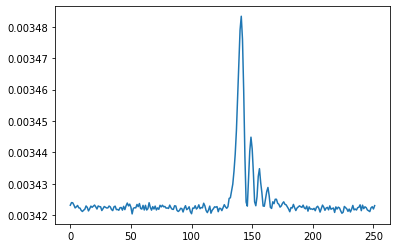

In [12]:
##### train for L=8 HEA layers
plt.plot(training_evolution.history["energy"][3000:])

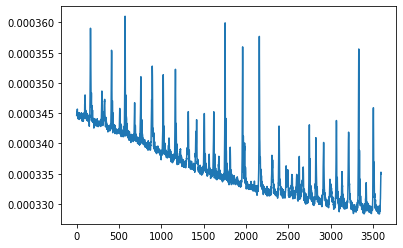

In [7]:
###tain for L=6 layers
plt.plot(training_evolution.history["energy"][5000:])

In [8]:
energy

<tf.Tensor: shape=(), dtype=float32, numpy=2.7913185e-05>

In [245]:



to_print="\nIteration #{}\nTime since beggining:{}\n best energy: {}\ncurrent_energy {}\n lower_bound: {}".format(0, datetime.now()-start, energy, energy, evaluator.accuracy_to_end)
print(to_print)
evaluator.displaying["information"]+=to_print

evaluator.add_step(indexed_circuit, symbol_to_value, energy, relevant=True)
evaluator.lowest_energy = energy

for iteration in range(1,reps+1):
    relevant=False

    ### create a mutation M (maybe this word is too fancy); we add (probably more than one) identity resolution
    iid.selector_temperature=scheduler_selector_temperature(energy, evaluator.lowest_energy, when_on=selector_temperature)
    M_indices, M_symbols_to_values, M_idx_to_symbols = iid.place_identities(indexed_circuit, symbol_to_value, rate_iids_per_step= rate_iids_per_step)

    ### simplify the circuit as much as possible
    Sindices, Ssymbols_to_values, Sindex_to_symbols = Simp.reduce_circuit(M_indices, M_symbols_to_values, M_idx_to_symbols)

    ## compute the energy of the mutated-simplified circuit [Note 1]
    MSenergy, MSsymbols_to_values, _ = auto_handler.autoencoder(
        Sindices, symbols_to_values=Ssymbols_to_values,
        parameter_perturbation_wall=scheduler_parameter_perturbation_wall(its_without_improvig=evaluator.its_without_improvig))

    if evaluator.accept_energy(MSenergy):
        indexed_circuit, symbol_to_value, index_to_symbols = Sindices, MSsymbols_to_values, Sindex_to_symbols
        # unitary slaughter: delete as many 1-qubit gates as possible, as long as the energy doesn't go up (we allow %1 increments per iteration)
        cnt=0
        reduced=True
        lmax=len(indexed_circuit)
        while reduced and cnt < lmax:
            indexed_circuit, symbol_to_value, index_to_symbols, energy, reduced = killer.unitary_slaughter(indexed_circuit, symbol_to_value, index_to_symbols)
            indexed_circuit, symbol_to_value, index_to_symbols = Simp.reduce_circuit(indexed_circuit, symbol_to_value, index_to_symbols)
            cnt+=1
        relevant=True
    evaluator.add_step(indexed_circuit, symbol_to_value, energy, relevant=relevant)

    to_print="\nIteration #{}\nTime since beggining:{}\n best energy: {}\ncurrent energy: {}\n lower_bound: {}".format(iteration, datetime.now()-start, evaluator.lowest_energy,energy, evaluator.accuracy_to_end)
    print(to_print)
    evaluator.displaying["information"]+=to_print

    evaluator.save_dicts_and_displaying()

    if evaluator.if_finish_ok is True:
        print("HOMEWORK DONE! \nBeers on me ;)")
        break

    if evaluator.its_without_improvig == wait_to_get_back:
        print("Getting back to favorite, it's been already {} iterations".format(wait_to_get_back))
        _, energy, indices, resolver, _, _ =  evaluator.evolution[evaluator.get_best_iteration()]
        evaluator.its_without_improvig = 0


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
beggining to train!

Iteration #0
Time since beggining:0:00:09.616356
 best energy: 0.009289397858083248
current_energy 0.009289397858083248
 lower_bound: 0.0


InvalidArgumentError: Could not find symbol in parameter map: th_24 [Op:TfqSimulateExpectation]

In [144]:
au = Autoencoder(n_qubits=4,problem_config=problem_config, nb=3)                        
fide, resolver, training_history = au.autoencoder(indexed_pure_states, resolver_pure_states, indexed_circuit)

TypeError: super(type, obj): obj must be an instance or subtype of type